In [1]:
import json
import os
import matplotlib.pyplot as plt
import pandas as pd
import glob
import numpy as np
from sklearn.metrics import mean_absolute_error
from matplotlib.ticker import ScalarFormatter
import statistics as stat

import proxima_analysis as pa

from IPython.core.display import display, HTML
display(HTML('<style>.container { width:100% !important; }</style>'))

BIG    = 22
MEDIUM = 20
FIGWIDTH=12
WIDTH = 0.25  # the width of the bars
NARROW=0.2

XLINE  = 523.21
YLINE  = 0.002

colors = ['#E27100', '#1b85b8', '#559e83', '#b26167']

# Starting to define standardized colors
MAE_COLOR =colors[1]
TIME_COLOR=colors[0]

FIXED_COLOR  = 'tbd'
STATIC_COLOR = 'tbd'
DYNAMIC_COLOR= 'tbd'

FIXED_MARKER='tbd'
STATIC_MARKER='tbd'
DYNAMIC_MARKER='tbd'

In [2]:
experiments = [
    'NORT-Proxima_dynamicalpha', #Proxima - dynamic alpha with no retrain interval, surrogate limits in place
    'NORT-Proxima_static-alpha', #Proxima - precalcualted alpha, no retrain interval, surrogate limits in place
    'surrogate_only', ## Simple surrogate implementation
    'SS-UQ02-NORT_staticalpha', # Simple surrogate, uq:0.2, no retrain interval, surrogate limits in place
    'DA_RT50', ## Proxima - dynamica alpha, testing single RT interval of 50, surrogate limits in place
    'DAallUQ_TEMP1000', ## Proxima - testing different retrain intervals and UQ's, surrogate limits in place
    'SST1000_bestparameters', ## Simple surrogate - with different Retrain intervals tested
    'SS_RI300', ## Simple Surrogate with RI 300
    'SS-UQ02_I50', ## Simple surrogate, uq: 0.2, All temps, RI: 50
    'SS-UQall_I50', ## Simple surrogate,, all UQ, Temp: 500, RI: 50
    'surrogate-all_params', ## Simple surrogate, all uq, 500,1000K, RI: 1,50(for 500K), 100,500(1000K)
    'dyn_nostreak', ##Proxima - dynamic alpha, no surrogate streak option
    'SS-500k_allparams', ## Simple surrogate, all uq, 500k, RI: 1,50, 100-500
    'ss1000K_0207', ## Simple surrogate, uq 0.2-0.7, RI:1,2,5-50, 100-500
    '500_3best', ## SS, using best 3 sets (UQ+RI) for 500K, running across all temperatures
    '1000_3best', ## SS, using best 3 sets (UQ+RI) for 1000K, running across all temperatures
    'static-ns_lazy111220', ##Proxima - static alpha, no surrogate streak option
]
root_path = '../proxima_data'

# 1) Scatter Plot Method Comparison

## Loading HF Results

In [3]:
#root_path_hf = '/home/yzamora/proxima/examples/molecule-sampling'
path_str = '/'.join([root_path,'runtime_s1_data.csv'])
hf_times = pd.read_csv(path_str)

results = {n: None for n in experiments}
for name in results:
    path_str = "/".join([root_path, name, "*"])
    path = glob.glob(path_str)
    uq_thresholds, int_list, total_time, uq_time, speed_up = pa.process_times(path,hf_times)
    time_df = pa.time_to_df(uq_time)
    speedup_df = pa.speedup_to_df(speed_up)
    mae_values = pa.process_mae(path)
    mae_df = pa.mae_to_df(mae_values)
    #results[name] = time_df.merge(mae_df, on=["uq", "interval","temperature"], how="inner")
    time_mae = time_df.merge(mae_df, on=["uq", "interval","temperature"], how="inner")
    results[name]=speedup_df.merge(time_mae, on=["uq", "interval","temperature"], how="inner")

## Graphing HF time against temperature

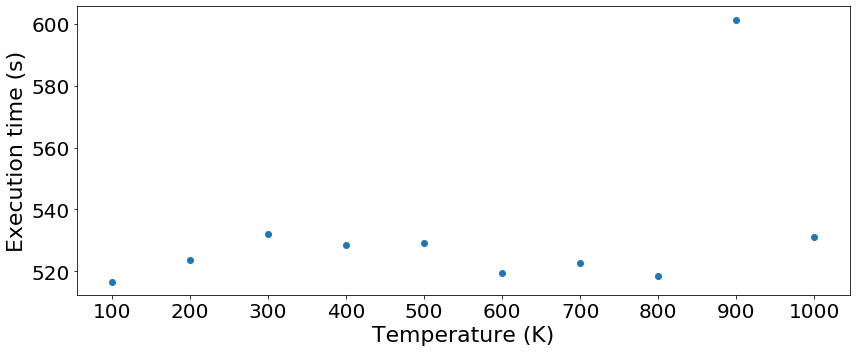

In [4]:
plt.subplots(figsize=(FIGWIDTH,5))
plt.plot(hf_times['Temp[K]'], hf_times['Runtime[s]'], 'o')

plt.xlabel('Temperature (K)', fontsize=BIG)
plt.ylabel('Execution time (s)', fontsize=BIG)
plt.xticks(hf_times['Temp[K]'])
plt.xticks(fontsize=MEDIUM)
plt.yticks(fontsize=MEDIUM)
plt.tight_layout()
plt.savefig('Figures/TF_times.pdf')

## Graphing MAE VS Time results of surrogate implementation
### A) Original plot_cases

In [5]:
def _plot_cases(cases):
    fig, ax = plt.subplots(figsize=(FIGWIDTH,5))
    for case in cases:
        df     = case.get('df')
        x      = case.get('x')
        y      = case.get('y')
        t      = case.get('t', None)
        s      = case.get('s', 36)
        color  = case.get('color', 'Black')
        label  = case.get('label', None)
        marker = case.get('marker', 'o')
        minor  = case.get('minor', False)
        legend = case.get('legend', True)
        # Following change is so that we can have hollow markers, which are easier to see when overlapping
        data = [(x,y) for (x,y) in zip(df[x], df[y])]
        my_x, my_y = zip(*data)
        plt.scatter(x=my_x, y=my_y, color=color, label=label, facecolors='none', marker=marker, s=s)
        if t!=None:
            data   = [(x,y,t) for (x,y,t) in zip(df[x], df[y], df[t])]
            for x, y, t in data:
                ax.annotate(t, (x, y+0.0002), rotation=90)

    ax.set_ylim([0.0, 0.009])
    ax.set_xscale('log')
    ax.ticklabel_format(axis='y', style='scientific', scilimits=(0,0), useMathText=True)
    ax.xaxis.set_major_formatter(ScalarFormatter())
    ax.tick_params(which='major', length=7, width=2)
    ax.tick_params(which='minor', length=4, width=1.5)
    if minor:
        ax.xaxis.set_minor_formatter(ScalarFormatter())
        for tick in ax.xaxis.get_minor_ticks():
            tick.label.set_fontsize(MEDIUM) 
    ax.axvline(x=XLINE, color=TIME_COLOR, linewidth=1)
    ax.axhline(y=0.002, color=MAE_COLOR,  linewidth=1)
    plt.xlabel('Execution time',      fontsize=BIG)
    plt.ylabel('Mean absolute error', fontsize=BIG)
    plt.xticks(fontsize=MEDIUM)
    plt.yticks(fontsize=MEDIUM)
        
    ax.yaxis.get_offset_text().set_fontsize(MEDIUM)
    if legend:
        ax.legend(fontsize=BIG, markerscale=2)
    plt.tight_layout()

### B) Modified plot_cases

In [6]:
def _plot_cases_adapted(cases): #df_a, df_b, df_c, df_d):
    fig, ax = plt.subplots(figsize=(FIGWIDTH,5))
    for case in cases:
        df     = case.get('df')
        x      = case.get('x')
        y      = case.get('y')
        
        good   = [(x,y,t,i) for (x,y,t,i) in zip(df[x], df[y], df['uq'], df['interval']) if x < XLINE and y < YLINE]
        hiTime = [(x,y) for (x,y) in zip(df[x], df[y]) if x >= XLINE]
        hiMAE  = [(x,y) for (x,y) in zip(df[x], df[y]) if x < XLINE and y >= YLINE]
        good_x, good_y, _, _ = zip(*good)
        hiTime_x, hiTime_y   = zip(*hiTime)
        hiMAE_x, hiMAE_y     = zip(*hiMAE)
        plt.scatter(x=good_x,   y=good_y,   color='g',       facecolors='none', marker='s', s=36)
        plt.scatter(x=hiMAE_x,  y=hiMAE_y,  color=colors[1], facecolors='none', marker='v', s=36)
        plt.scatter(x=hiTime_x, y=hiTime_y, color=colors[0], facecolors='none', marker='o', s=36)
        # Customized position code. But then the whole function is customized...
        for x, y, t, i in good:
            if t==0.2:
                if i==50:
                    ax.annotate(f'{t}, {i}', (x-110, y-0.0005), color='green', fontsize=12)
                else:
                    ax.annotate(f'{t}, {i}', (x-95, y-0.0005), color='green', fontsize=12)
            else:
                ax.annotate(f'{t}, {i}', (x-50, y-0.0005), color='green', fontsize=12)

    ax.set_ylim([0.0, 0.009])
    ax.set_xscale('log')
    ax.ticklabel_format(axis='y', style='scientific', useMathText=True, scilimits=(0,0))
    ax.xaxis.set_major_formatter(ScalarFormatter())
    ax.tick_params(which='major', length=7, width=2)
    ax.tick_params(which='minor', length=4, width=1.5)
    ax.axvline(x=XLINE, color=TIME_COLOR, linewidth=1)
    ax.axhline(y=0.002, color=MAE_COLOR,  linewidth=1)
    
    plt.xlabel('Execution time',      fontsize=BIG)
    plt.ylabel('Mean absolute error', fontsize=BIG)
    plt.xticks(fontsize=MEDIUM)
    plt.yticks(fontsize=MEDIUM)
    ax.yaxis.get_offset_text().set_fontsize(MEDIUM)
    
    #plt.text(560,   0.0072, 'Baseline time', rotation=90, color=colors[0], fontsize=BIG-1)
    plt.text(560,   0.0032, 'Baseline time', rotation=90, color=TIME_COLOR, fontsize=BIG)
    plt.text(13000, 0.0023, 'Target MAE',                 color=MAE_COLOR, fontsize=BIG)
    
    plt.text(50,    0.0008, 'N='+str(len(good_x)),     color='g',       fontsize=BIG)
    plt.text(250,   0.007,  'N='+str(len(hiMAE_x)),    color=colors[1], fontsize=BIG)    
    plt.text(10000, 0.0008, 'N='+str(len(hiTime_x)), color=colors[0], fontsize=BIG)
    
    plt.scatter([XLINE], [0], color='r', marker='o', s=36, clip_on=False)
    #plt.scatter([441.544], [0.001595],   color='r', marker='o', facecolors='none', linewidths=2, s=60)
    

    from matplotlib.lines import Line2D
    custom_lines = [Line2D([0], [0], marker='s', markersize=10,  markerfacecolor='none', color='g',       lw=0),
                    Line2D([0], [0], marker='v', markersize=10,  markerfacecolor='none', color=colors[1], lw=0),
                    Line2D([0], [0], marker='o', markersize=10,  markerfacecolor='none', color=colors[0], lw=0),
                    Line2D([0], [0], marker='o', markersize=10,  color='r', lw=0)]
    ax.legend(custom_lines, ['Acceptable', 'MAE too high', 'Runtime too long', 'Target function only'], fontsize=BIG)

    plt.tight_layout()

In [7]:
data = 'SS-500k_allparams'
#data = 'ss1000K_0207'
r = results[data]
tg_time = 529.334 #500k time
#tg_time = 531.0756 #1000k time
mae_target = 0.002
print(r[(r['time']<tg_time) & (r['mae']<mae_target) & (r['temperature']==500)])
df = results[data]
df2 = df[df['temperature']==500]
print(sorted(list(set(list(df2['uq'])))))

     uq  interval  temperature  speed_up     time       mae
17  0.2       100          500     1.269  417.063  0.001556
21  0.2       200          500     1.225  432.083  0.000721
32  0.2        50          500     1.154  458.786  0.000665
38  0.3       200          500     2.439  217.011  0.001496
49  0.3        50          500     2.314  228.795  0.001788
[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]


In [8]:
#data = 'SS-500k_allparams'
data = 'ss1000K_0207'
r = results[data]
#tg_time = 523.21 #500k time
tg_time = 531.0756 #1000k time
mae_target = 0.002
print(r[(r['time']<tg_time) & (r['mae']<mae_target) & (r['temperature']==1000)])
df = results[data]
df2 = df[df['temperature']==1000]
print(sorted(list(set(list(df2['uq'])))))

     uq  interval  temperature  speed_up     time       mae
0   0.2       100         1000     1.004  528.934  0.000755
4   0.2       200         1000     1.136  467.638  0.000997
8   0.2       300         1000     1.200  442.409  0.001595
18  0.3        10         1000     1.509  351.828  0.001613
19  0.3        15         1000     1.692  313.861  0.001661
22  0.3        20         1000     1.754  302.694  0.001708
23  0.3        25         1000     1.844  287.931  0.001856
26  0.3        30         1000     1.924  275.967  0.001772
27  0.3        35         1000     1.936  274.357  0.001807
29  0.3        40         1000     1.964  270.427  0.001833
30  0.3        45         1000     2.015  263.570  0.001821
32  0.3        50         1000     1.990  266.876  0.001717
33  0.3         5         1000     1.144  464.156  0.001455
37  0.4         1         1000     1.174  452.377  0.001845
41  0.4         2         1000     1.721  308.633  0.001919
[0.2, 0.3, 0.4, 0.5, 0.6, 0.7]


# Simple Surrogate Implementation
Results of tests with 
uq = 01.-0.7,
Temp=500
Retrain interval = 1,2,5-45(in intervals of 5)
Extreme RI 100-500

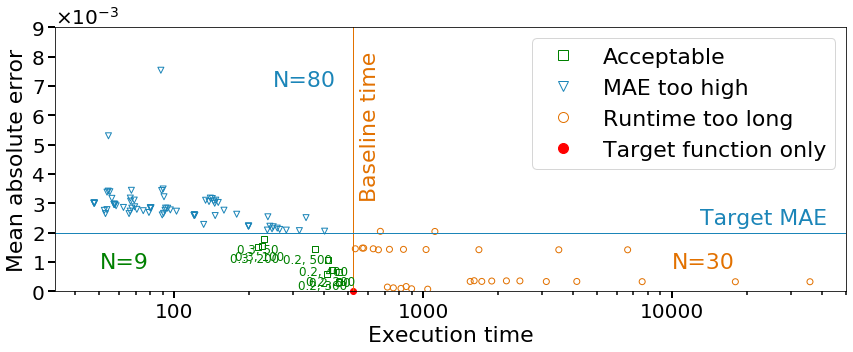

In [9]:
df = results['surrogate-all_params']
#df =results['SS-500k_allparams']
df2 = df[df['temperature']==500]
cases = (
        {'df': df2, 'x':'time', 'y':'mae', 'color':'Green', 'marker':'x'},
    )
_plot_cases_adapted(cases)
plt.savefig('Figures/ss_extremeparams.pdf')
plt.show()

## Simple Surrogate
Only retrain intervals from 1,2,5- 50,100-500

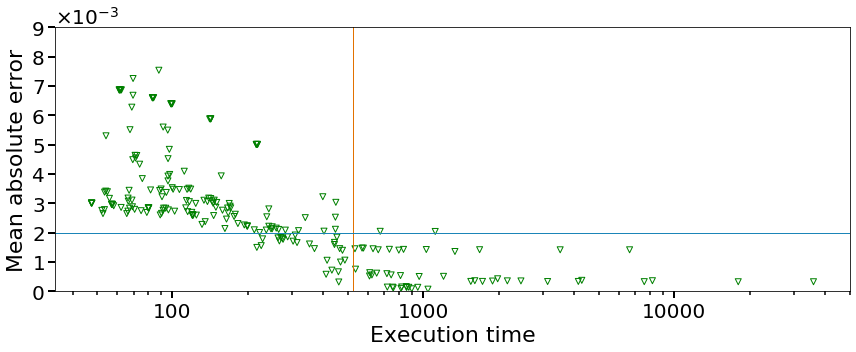

In [10]:
cases = (
        {'df': results['surrogate-all_params'], 'x':'time', 'y':'mae', 'color':'Green', 'marker':'v', 'legend':False},
    )
_plot_cases(cases)
plt.savefig('Figures/ss_allparams.pdf')

## Best parameter results
Best parameters found after parameter sweep using 500K, 1000K

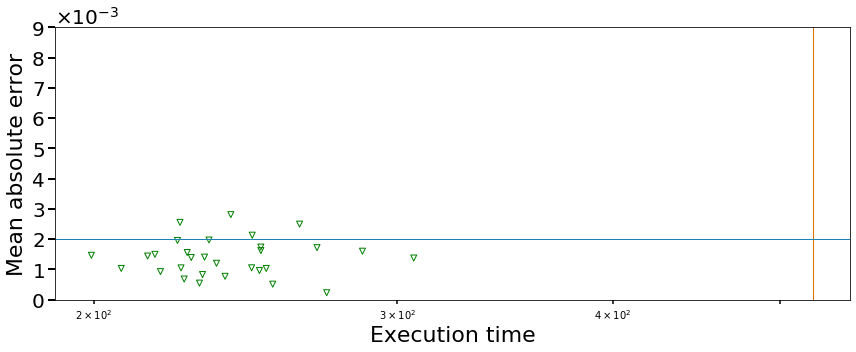

In [11]:
cases = (
        {'df': results['500_3best'], 'x':'time', 'y':'mae', 'color':'Green', 'marker':'v', 'legend':False},
    )
_plot_cases(cases)
plt.savefig('Figures/500_3best.pdf')

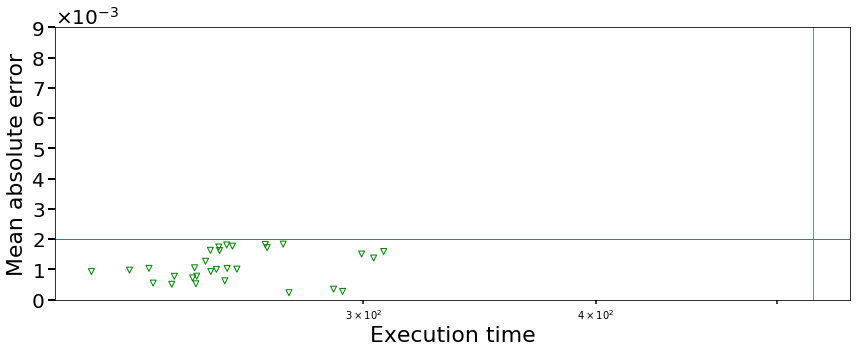

In [12]:
cases = (
        {'df': results['1000_3best'], 'x':'time', 'y':'mae', 'color':'Green', 'marker':'v', 'legend':False},
    )
_plot_cases(cases)
plt.savefig('Figures/1000_3best.pdf')

## Looking through all surrogate parameters

In [13]:
"""bs = results['SST1000_bestparameters']
bs[bs['interval']==400]
bs[bs['mae']<0.002]"""

"bs = results['SST1000_bestparameters']\nbs[bs['interval']==400]\nbs[bs['mae']<0.002]"

## SS implementation - No Retrain Interval
UQ=0.2 No retraining interval

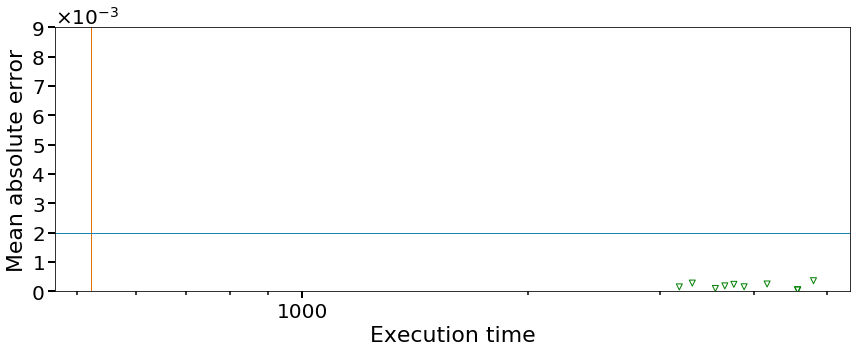

In [14]:
cases = (
        #{'df': results['SS-UQ02-NORT_staticalpha'], 'x':'time', 'y':'mae','t': 'temperature', 'color':'Green', 'marker':'x', 'legend':False},
        {'df': results['SS-UQ02-NORT_staticalpha'], 'x':'time', 'y':'mae', 'color':'Green', 'marker':'v', 'legend':False},
    )
_plot_cases(cases)
plt.savefig('Figures/ss_nort.pdf')

# Simple Surrogate Implementation VS Proxima -- NO RI
Results of tests with 
uq = 0.2
Retrain interval = No retrain interval specified

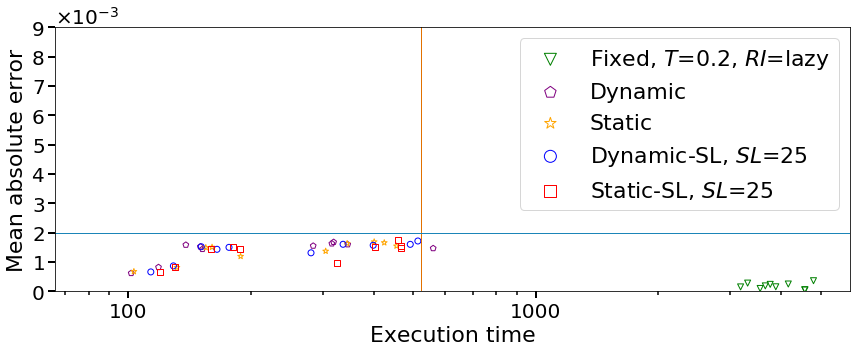

In [15]:
cases = (
        #{'df': results['SS-UQ02-NORT_staticalpha'],  'x':'time', 'y':'mae', 't': 'temperature', 'color':'Green', 'label':r'Fixed,  $T$=0.2, $RI$=lazy',           'marker':'x'},
        #{'df': results['NORT-Proxima_dynamicalpha'], 'x':'time', 'y':'mae', 't': 'temperature', 'color':'Blue',  'label':'Dynamic', 'marker':'o'},
        #{'df': results['NORT-Proxima_static-alpha'], 'x':'time', 'y':'mae', 't': 'temperature', 'color':'REd',   'label':'Static',  'marker':'s'},
        {'df': results['SS-UQ02-NORT_staticalpha'],  'x':'time', 'y':'mae', 'color':'Green', 'label':r'Fixed, $T$=0.2, $RI$=lazy', 'marker':'v'},
        {'df': results['dyn_nostreak'], 'x':'time', 'y':'mae', 'color':'Purple', 'label':'Dynamic', 'marker':'p', 'minor':True},
        {'df': results['static-ns_lazy111220'], 'x':'time', 'y':'mae', 'color':'Orange', 'label':'Static', 'marker':'*', 'minor':True},
        {'df': results['NORT-Proxima_dynamicalpha'], 'x':'time', 'y':'mae', 'color':'Blue',  'label':'Dynamic-SL, $SL$=25', 'marker':'o'},
        {'df': results['NORT-Proxima_static-alpha'], 'x':'time', 'y':'mae', 'color':'Red',   'label':'Static-SL, $SL$=25',  'marker':'s'},
    )
_plot_cases(cases)
#plt.savefig('Figures/no_retrain.pdf')

## Simple Surrogate Implementation, best parameters- RI = 300
Results of tests with uq = 0.2 Retrain interval = 300

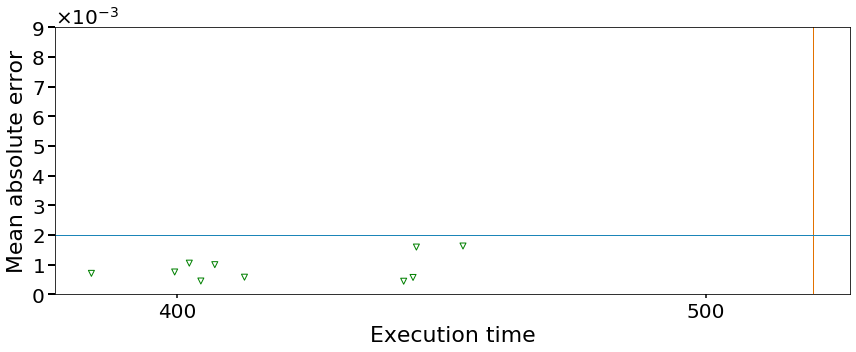

In [16]:
cases = (
        {'df': results['SS_RI300'], 'x':'time', 'y':'mae', 'color':'Green', 'marker':'v', 'minor':True, 'legend':False},
    )
_plot_cases(cases)
plt.savefig('Figures/ss_ri300.pdf')

## SS best parameters, RI=300 VS Proxima dynamic and static
UQ=0.2, RI=300

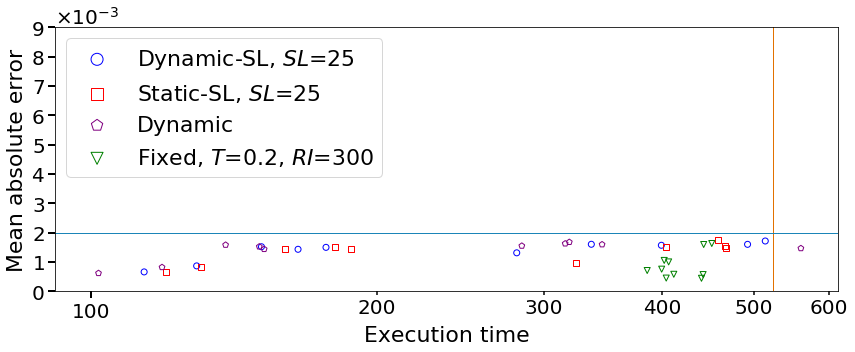

In [17]:
cases = (
        {'df': results['NORT-Proxima_dynamicalpha'], 'x':'time', 'y':'mae', 'color':'Blue', 'label':'Dynamic-SL, $SL$=25', 'marker':'o', 'minor':True},
        {'df': results['NORT-Proxima_static-alpha'], 'x':'time', 'y':'mae', 'color':'Red', 'label':'Static-SL, $SL$=25', 'marker':'s', 'minor':True},
        {'df': results['dyn_nostreak'], 'x':'time', 'y':'mae', 'color':'Purple', 'label':'Dynamic', 'marker':'p', 'minor':True},
        {'df': results['SS_RI300'], 'x':'time', 'y':'mae', 'color':'Green', 'label':r'Fixed, $T$=0.2, $RI$=300', 'marker':'v', 'minor':True},
    )
_plot_cases(cases)
plt.savefig('Figures/ThreeProx_scatter.pdf')

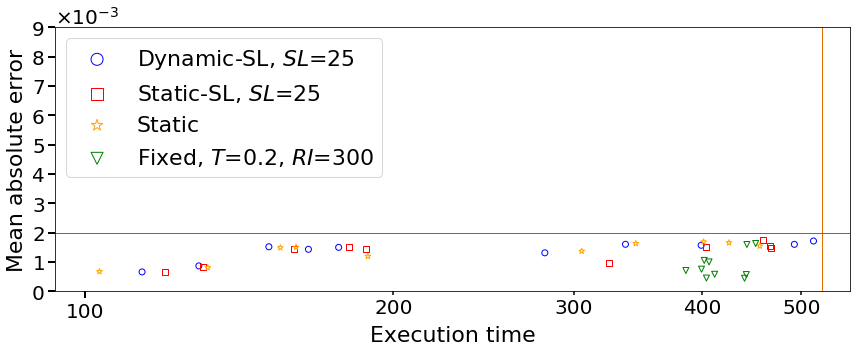

In [18]:
cases = (
        {'df': results['NORT-Proxima_dynamicalpha'], 'x':'time', 'y':'mae', 'color':'Blue', 'label':'Dynamic-SL, $SL$=25', 'marker':'o', 'minor':True},
        {'df': results['NORT-Proxima_static-alpha'], 'x':'time', 'y':'mae', 'color':'Red', 'label':'Static-SL, $SL$=25', 'marker':'s', 'minor':True},
        {'df': results['static-ns_lazy111220'], 'x':'time', 'y':'mae', 'color':'Orange', 'label':'Static', 'marker':'*', 'minor':True},
        #{'df': results['dyn_nostreak'], 'x':'time', 'y':'mae', 'color':'Purple', 'label':'Dynamic', 'marker':'p', 'minor':True},
        {'df': results['SS_RI300'], 'x':'time', 'y':'mae', 'color':'Green', 'label':r'Fixed, $T$=0.2, $RI$=300', 'marker':'v', 'minor':True},
    )
_plot_cases(cases)
#plt.savefig('Figures/ThreeProx_scatter.pdf')
#plt.savefig('Figures/ssbest_prox.pdf') ## not including Dynamic Proxima without streak check

# Plotting other comparisons

## Dynamic VS Static VS Simple Surrogate 
No retrain interval for Proxima implementations 

Simple surrogate implementation results are of all UQ and RI combinations

'NORT-Proxima_dynamicalpha', 'NORT-Proxima_static-alpha', 'surrogate_only'

All temperatures for Proxima - 500K for surrogate

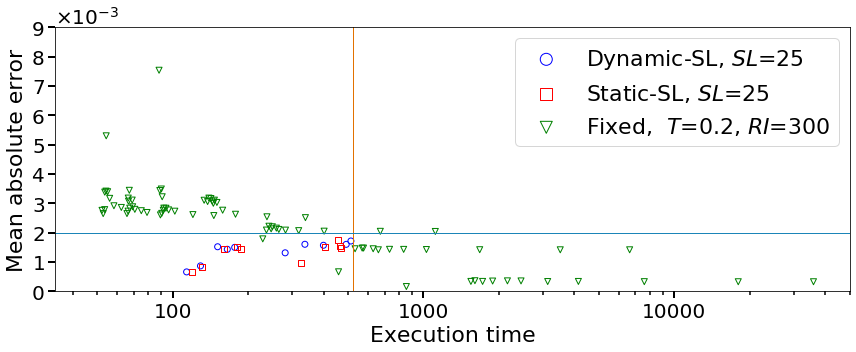

In [19]:
cases = (
        {'df': results['NORT-Proxima_dynamicalpha'], 'x':'time', 'y':'mae', 'color':'Blue', 'label':'Dynamic-SL, $SL$=25', 'marker':'o'},
        {'df': results['NORT-Proxima_static-alpha'], 'x':'time', 'y':'mae', 'color':'REd', 'label':'Static-SL, $SL$=25', 'marker':'s'},
        {'df': results['surrogate_only'], 'x':'time', 'y':'mae', 'color':'Green', 'label':'Fixed,  $T$=0.2, $RI$=300', 'marker':'v'},
    )
_plot_cases(cases)

## No retrain interval comparison - Tests across all temperatures
No retrain interval used on all methods
UQ = 0.2 for simple surrogate to keep under MAE for all temperatures
Temperatures of 100 - 1000K, in increments of 100 tested 

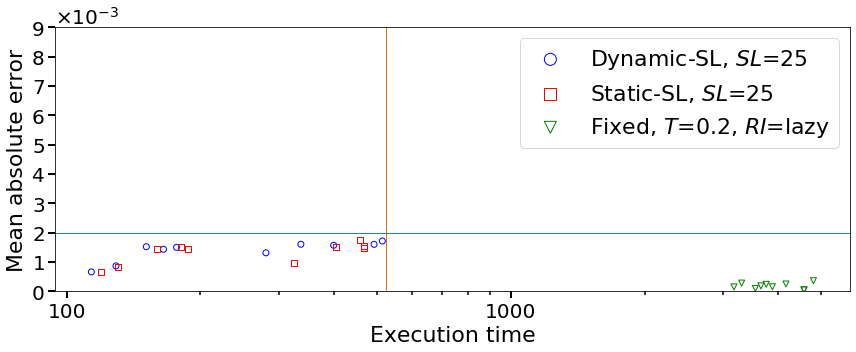

In [20]:
cases = (
        {'df': results['NORT-Proxima_dynamicalpha'], 'x':'time', 'y':'mae', 'color':'Blue', 'label':'Dynamic-SL, $SL$=25', 'marker':'o'},
        {'df': results['NORT-Proxima_static-alpha'], 'x':'time', 'y':'mae', 'color':'REd', 'label':'Static-SL, $SL$=25', 'marker':'s'},
        {'df': results['SS-UQ02-NORT_staticalpha'], 'x':'time', 'y':'mae', 'color':'Green', 'label':r'Fixed, $T$=0.2, $RI$=lazy', 'marker':'v'},
    )
_plot_cases(cases)

## Comparing Proxima implementations
Using Retrain Interval VS predetermined retrain interval

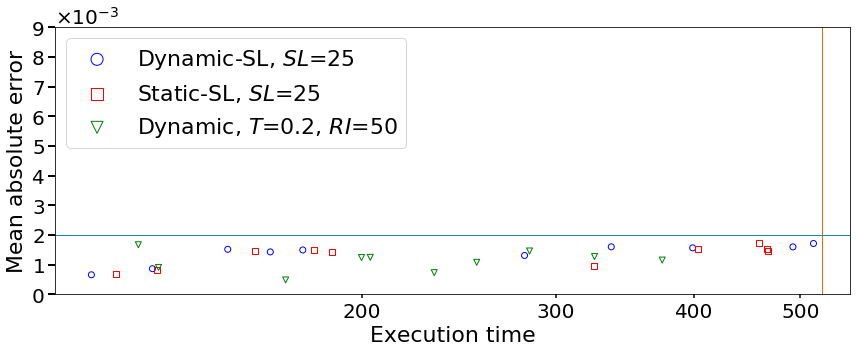

In [21]:

cases = (
        {'df': results['NORT-Proxima_dynamicalpha'], 'x':'time', 'y':'mae', 'color':'Blue', 'label':'Dynamic-SL, $SL$=25', 'marker':'o', 'minor':True},
        {'df': results['NORT-Proxima_static-alpha'], 'x':'time', 'y':'mae', 'color':'Red', 'label':'Static-SL, $SL$=25', 'marker':'s', 'minor':True},
        {'df': results['DA_RT50'], 'x':'time', 'y':'mae', 'color':'Green', 'label':r'Dynamic, $T$=0.2, $RI$=50', 'marker':'v', 'minor':True},
    )
_plot_cases(cases)

## Dynamic Proxima compared with simple surrogate with RI 300

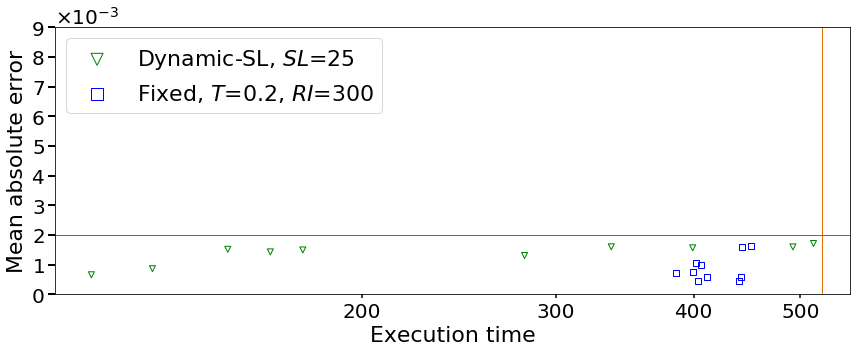

In [22]:
cases = (
        {'df': results['NORT-Proxima_dynamicalpha'], 'x':'time', 'y':'mae', 'color':'Green', 'label':'Dynamic-SL, $SL$=25', 'marker':'v', 'minor':True},
        {'df': results['SS_RI300'], 'x':'time', 'y':'mae', 'color':'Blue', 'label':r'Fixed, $T$=0.2, $RI$=300', 'marker':'s', 'minor':True},
    )
_plot_cases(cases)

## Mixed results  - Dynamic Proxima compared with simple surrogate
Dyanamic proxima is run using constant temperature (1,000K)

UQ = 0.1 - 0.7
Retrain Interval = 1,2,5-45,increments of 5
And Retrain Intervals = 100-500, increments of 50

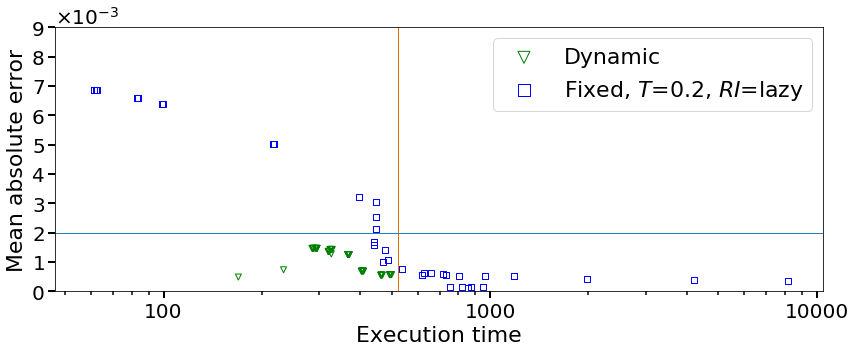

In [23]:
cases = (
        {'df': results['DAallUQ_TEMP1000'], 'x':'time', 'y':'mae', 'color':'Green', 'label':'Dynamic', 'marker':'v'},
        {'df': results['SST1000_bestparameters'], 'x':'time', 'y':'mae', 'color':'Blue', 'label':r'Fixed, $T$=0.2, $RI$=lazy', 'marker':'s'},
    )
_plot_cases(cases)

# ROG Comparisons

## Target function Only - ROG

In [24]:
hf_rog = "/".join([root_path,'hf_rog','*'])
hg_f = glob.glob(hf_rog)
hf_tf = {}
for f in hg_f:
    temp = os.path.basename(f).split('_')[1].split('.')[0]
    with  open(f) as data:
        hf_tf[temp] = json.loads(data.read())


## Dynamic Proxima - ROG

In [25]:
run_name = 'dyn_ns_lazy111220'
file = "/".join([root_path, run_name,'*'])
hf_d = {}
files = glob.glob(file)
for f in files:
    control_fn = os.path.basename(f).split('_')
    temp = control_fn[6]
    with open(f + '/result.json') as data:
        hf_d[temp] = json.loads(data.read())


In [26]:
run_name = 'static-ns_lazy111220'
file = "/".join([root_path, run_name,'*'])
hf_s = {}
files = glob.glob(file)
for f in files:
    control_fn = os.path.basename(f).split('_')
    temp = control_fn[6]
    with open(f + '/result.json') as data:
        hf_s[temp] = json.loads(data.read())


In [27]:
temp_mean_d = {}
temp_minerror_d = {}
temp_maxerror_d = {}
for k in hf_d:
    temp_mean_d[int(k)] = hf_d[k]['r_g']['statistic']
    temp_minerror_d[int(k)] = hf_d[k]['r_g']['minmax'][0]
    temp_maxerror_d[int(k)] = hf_d[k]['r_g']['minmax'][1]
    
temp_mean_target = {}
temp_minerror_target = {}
temp_maxerror_target= {}
for k in hf_tf:
    temp_mean_target[int(k)] = hf_tf[k]['r_g']['statistic']
    temp_minerror_target[int(k)] = hf_tf[k]['r_g']['minmax'][0]
    temp_maxerror_target[int(k)] = hf_tf[k]['r_g']['minmax'][1]

temp_mean_static = {}
temp_minerror_static = {}
temp_maxerror_static = {}
for k in hf_s:
    temp_mean_static[int(k)] = hf_s[k]['r_g']['statistic']
    temp_minerror_static[int(k)] = hf_s[k]['r_g']['minmax'][0]
    temp_maxerror_static[int(k)] = hf_s[k]['r_g']['minmax'][1]
    

In [28]:
def sorting_dic(_t_mean_d,_temp_minerror_d,_temp_maxerror_d):
    
    t_mean_d,temp_minerror_d,temp_maxerror_d = (
        _t_mean_d.copy(),_temp_minerror_d.copy(),_temp_maxerror_d.copy()
    )
    
    t_mean_d = sorted(t_mean_d.items())
    temp_d,mean_d = zip(*t_mean_d)

    temp_minerror_d = sorted(temp_minerror_d.items())
    temp_d,minerror_d = zip(*temp_minerror_d )

    temp_maxerror_d = sorted(temp_maxerror_d.items())
    temp_d,maxerror_d = zip(*temp_maxerror_d )
    
    return temp_d,mean_d,minerror_d,maxerror_d

temp_d,mean_d,minerror_d,maxerror_d = sorting_dic(temp_mean_d,temp_minerror_d,temp_maxerror_d)
temp_t,mean_t,minerror_t,maxerror_t = sorting_dic(temp_mean_target,temp_minerror_target,temp_maxerror_target)
temp_s,mean_s,minerror_s,maxerror_s = sorting_dic(temp_mean_static,temp_minerror_static,temp_maxerror_static)

"""t_mean_t = sorted(temp_mean_target.items())
temp_t,mean_t = zip(*t_mean_t)

t_mean_s = sorted(temp_mean_static.items())
temp_s,mean_s = zip(*t_mean_s)"""

't_mean_t = sorted(temp_mean_target.items())\ntemp_t,mean_t = zip(*t_mean_t)\n\nt_mean_s = sorted(temp_mean_static.items())\ntemp_s,mean_s = zip(*t_mean_s)'

In [29]:
d_mins = np.array(mean_d) - np.array(minerror_d)
d_maxes = np.array(maxerror_d) - np.array(mean_d)

t_mins = np.array(mean_t) - np.array(minerror_t)
t_maxes = np.array(maxerror_t) - np.array(mean_t)

s_mins = np.array(mean_s) - np.array(minerror_s)
s_maxes = np.array(maxerror_s) - np.array(mean_s)

Text(0, 0.5, 'Mean RoG')

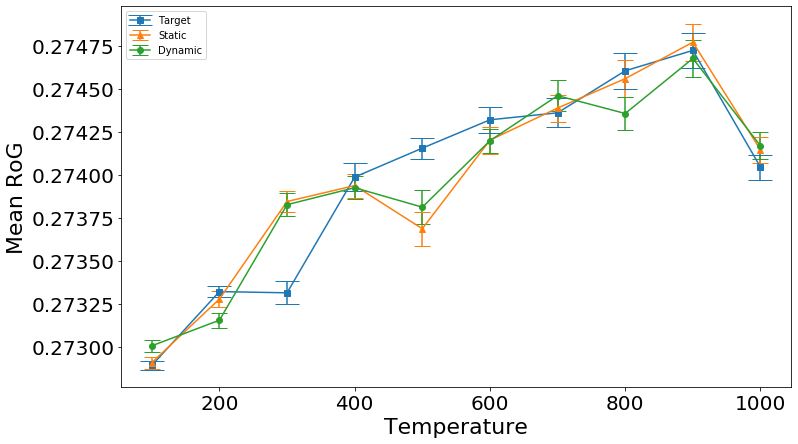

In [30]:
fig, ax = plt.subplots(figsize=(FIGWIDTH,7))

plt.xlabel('Execution time',fontsize=BIG)
plt.ylabel('Mean absolute error', fontsize=BIG)
plt.xticks(fontsize=MEDIUM)
plt.yticks(fontsize=MEDIUM)
ax.yaxis.get_offset_text().set_fontsize(MEDIUM)
ax.errorbar(temp_t,mean_t,yerr=[t_mins,t_maxes],label='Target', capsize=12.0, fmt="s-")
ax.errorbar(temp_s,mean_s,yerr=[s_mins,s_maxes],label='Static', capsize=8.0, fmt="^-")
ax.errorbar(temp_d,mean_d,yerr=[d_mins,d_maxes],label='Dynamic', capsize=8.0, fmt="o-")

plt.legend()
plt.xlabel('Temperature')
plt.ylabel('Mean RoG')

# 2) Energy computations

In [31]:
def get_true_run(true_energy, surrogate_energy_true, surrogate_energy_values):
    e_true = np.array(true_energy[0:])
    e_used = np.array(true_energy[0:])
    for s, e in zip(surrogate_energy_true['step'], surrogate_energy_values):
        e_used[s-1] = e
    return e_used

## Singular Energy trajectory Graph

In [32]:
def generate_energy_graph(kind):
    offset = -1081.0115
    if kind=='simple':
        app = "08Oct20-205633_p_0.003_uq_0.2_T_500_I_300_M_1" ## Can find single results in data directory
        results = pd.read_csv(root_path + "/SS_RI300/"+ app + "/tests_run_data.csv")
    else:
        app = "14Oct20-151642_p_0.003_uq_0.5_T_500_I_1_M_1" ## Can find single results in data directory
        results = pd.read_csv(root_path + "/NORT-Proxima_dynamicalpha/"+ app + "/tests_run_data.csv")

    fig, ax = plt.subplots(figsize=(FIGWIDTH,7))
    
    surrogate_energy_true = results[results['surrogate'] == True]
    surrogate_energy_values = surrogate_energy_true['surrogate_energy']
    new_energy = results[results['surrogate']== False]
    new_energy_val = new_energy['new_energy']
    true_energy = results['true_new_energy']

    plt.plot(results['step'], true_energy[0:]-offset, 'v', fillstyle='none', color=colors[0], markersize=5, label='Target function result')
    plt.plot(surrogate_energy_true['step'], surrogate_energy_values-offset, 'o', fillstyle='none', color=colors[1], markersize=5, label='Surrogate model result')
    plt.plot(new_energy['step'], new_energy_val-offset, 's', markersize=5, fillstyle='none', color='g', label='Target function call')
    ax.ticklabel_format(axis='y', style='scientific', scilimits=(0,0), useMathText=True) # useOffset=False)
    #ax.ticklabel_format(axis='y',style='scientific',scilimits=(-3,3))
    plt.xticks(fontsize=MEDIUM)
    plt.yticks(fontsize=MEDIUM)
    ax.yaxis.get_offset_text().set_fontsize(MEDIUM)

    plt.ylabel('Relative energy', fontsize=BIG)
    plt.xlabel('Steps', fontsize=BIG)
    plt.legend(loc='upper left', fontsize=BIG, markerscale=2)
    plt.tight_layout()
    
    if kind=='simple':
        plt.savefig('Figures/SS_energy.pdf')
    else:
        plt.savefig('Figures/dyn_energy.pdf')

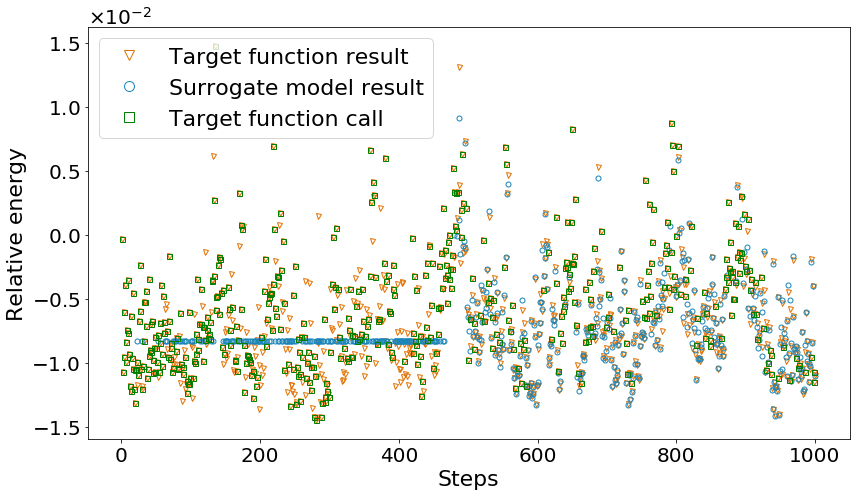

In [33]:
generate_energy_graph('simple')

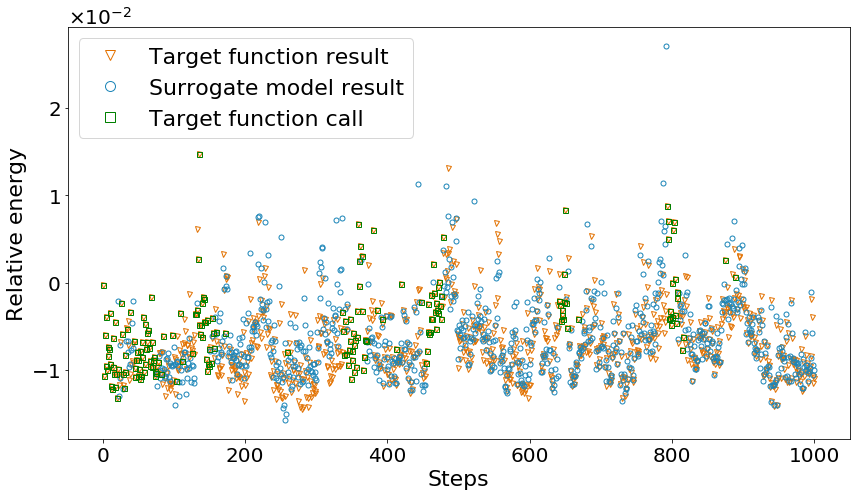

In [34]:
generate_energy_graph('other')

## Control changes by step

In [35]:
"""## Singular run - testing space
run_name = 'dyn-ns_lazy111220'
app = '12Nov20-055405_p_0.003_uq_0.5_T_100_I_1_M_1'
#"/".join([root_path, run_name,app, "tests_run_data.csv"])
file = "/".join([root_path, run_name,app, "tests_run_data.csv"])
results = pd.read_csv(file)

#reading in control data
f_cc = open(root_path + "/" + run_name + "_T_change" +"/control_uq12Nov20-055405_UQ_0.5_T_100_I_1_M_1.txt","r")
fcc_results = np.loadtxt(f_cc)

#reading in alpha data
alpha = open(root_path + '/' + 'alpha_dynlazyns/' + 'alpha_dynlazyns_100K.txt', 'r')
alpha_results = np.loadtxt(alpha, dtype='object')
alpha_results = np.where(alpha_results == 'None', np.nan,alpha_results)
alpha_results = alpha_results.astype(np.float)
results_100["tolerance"] = fcc_results
results_100["alpha"] = alpha_results"""

'## Singular run - testing space\nrun_name = \'dyn-ns_lazy111220\'\napp = \'12Nov20-055405_p_0.003_uq_0.5_T_100_I_1_M_1\'\n#"/".join([root_path, run_name,app, "tests_run_data.csv"])\nfile = "/".join([root_path, run_name,app, "tests_run_data.csv"])\nresults = pd.read_csv(file)\n\n#reading in control data\nf_cc = open(root_path + "/" + run_name + "_T_change" +"/control_uq12Nov20-055405_UQ_0.5_T_100_I_1_M_1.txt","r")\nfcc_results = np.loadtxt(f_cc)\n\n#reading in alpha data\nalpha = open(root_path + \'/\' + \'alpha_dynlazyns/\' + \'alpha_dynlazyns_100K.txt\', \'r\')\nalpha_results = np.loadtxt(alpha, dtype=\'object\')\nalpha_results = np.where(alpha_results == \'None\', np.nan,alpha_results)\nalpha_results = alpha_results.astype(np.float)\nresults_100["tolerance"] = fcc_results\nresults_100["alpha"] = alpha_results'

## Adding alpha and tolerance changes 
Running through all dynamic testing -

In [36]:
run_name = 'dyn_ns_lazy111220'
alpha_run = 'alpha_dynlazyns'
control_name = run_name + '_T_change'

file = "/".join([root_path, run_name,'*'])
results_d = {}
files = glob.glob(file)
for f in files:
    control_fn = os.path.basename(f).split('_')
    temp_c = control_fn[6]
    results_d[temp_c] = pd.read_csv(f + '/tests_run_data.csv')
    temp_a = temp_c +'k.txt'
    control_fn.pop(1)
    control_fn.pop(1)
    control_fn[1] = 'UQ'
    control_fn = 'control_uq' + '_'.join(control_fn)
    control_data = open("/".join([root_path,control_name,control_fn + '.txt']))
    control_results = np.loadtxt(control_data)
    
    alpha_data = open("/".join([root_path,alpha_run,alpha_run+'_'+temp_a]))
    alpha_results = np.loadtxt(alpha_data, dtype='object')
    alpha_results = np.where(alpha_results == 'None', np.nan,alpha_results)
    alpha_results = alpha_results.astype(np.float)
                                     
    results_d[temp_c]['tolerance'] = control_results
    results_d[temp_c]['alpha'] = alpha_results

## Static Proxima 
Precalcuting alpha and not changing

In [37]:
run_name = 'static-ns_lazy111220'
alpha_run = 'alpha_statlazyns'
control_name = run_name + '_T_change'

file = "/".join([root_path, run_name,'*'])
results_s = {}
files = glob.glob(file)
for f in files:
    control_fn = os.path.basename(f).split('_')
    temp_c = control_fn[6]
    results_s[temp_c] = pd.read_csv(f + '/tests_run_data.csv')
    temp_a = temp_c +'k.txt'
    control_fn.pop(1)
    control_fn.pop(1)
    control_fn[1] = 'UQ'
    control_fn = 'control_uq' + '_'.join(control_fn)
    control_data = open("/".join([root_path,control_name,control_fn + '.txt']))
    control_results = np.loadtxt(control_data)
    
    alpha_data = open("/".join([root_path,alpha_run,alpha_run+'_'+temp_a]))
    alpha_results = np.loadtxt(alpha_data, dtype='object')
    alpha_results = np.where(alpha_results == 'None', np.nan,alpha_results)
    alpha_results = alpha_results.astype(np.float)
                                  
    results_s[temp_c]['tolerance'] = control_results
    results_s[temp_c]['alpha'] = alpha_results


## Plotting alpha and tolerance changes

In [69]:
def graph_tol_alpha(variant, results, temp):
    TOLERANCE_COLOR = colors[0]
    ALPHA_COLOR = colors[1]
    TOLERANCE_LABEL = 'Tolerance'
    ALPHA_LABEL = 'Alpha'
    temp = str(temp) # temperature to plot
    fig, ax = plt.subplots(figsize=(FIGWIDTH,5))

    #plt.plot(results['500']['step'], results['500']['tolerance'], 'v', fillstyle='none', color=colors[0], markersize=5, label='Tolerance')
    p1, = plt.plot(results[temp]['step'], results[temp]['alpha'], 'o', fillstyle='none', color=ALPHA_COLOR, markersize=5, label=ALPHA_LABEL)

    ax.ticklabel_format(axis='y', style='scientific', scilimits=(0,0), useMathText=True) # useOffset=False)
    ax.ticklabel_format(axis='y',style='scientific',scilimits=(-3,3))
    h1, l1 = ax.get_legend_handles_labels()
    ax.set_ylabel('Alpha', fontsize=BIG, color=ALPHA_COLOR)
    plt.xticks(fontsize=MEDIUM)
    plt.yticks(fontsize=MEDIUM, color=ALPHA_COLOR)
    ax.set_ylim(0, 0.013)
    ax.yaxis.get_offset_text().set_fontsize(MEDIUM)
    ax.yaxis.get_offset_text().set_color(ALPHA_COLOR)

    ax2 = ax.twinx()
    p2, = plt.plot(results[temp]['step'], results[temp]['tolerance'], 'v', fillstyle='none', color=TOLERANCE_COLOR, markersize=5, label=TOLERANCE_LABEL)
    ax2.set_ylabel('Tolerance', fontsize=BIG, color=TOLERANCE_COLOR)
    h2, l2 = ax2.get_legend_handles_labels()
    ax2.set_ylim(bottom=0)
    ax2.ticklabel_format(axis='y',style='scientific',scilimits=(-3,3))
    plt.xticks(fontsize=MEDIUM)
    plt.yticks(fontsize=MEDIUM, color=TOLERANCE_COLOR)
    ax2.yaxis.get_offset_text().set_fontsize(MEDIUM)

    ax.set_xlabel('Steps', fontsize=BIG)
    
    legend = plt.legend([p1, p2], [ALPHA_LABEL, TOLERANCE_LABEL], markerscale=2, fontsize=BIG) # loc='upper left')
    texts = legend.get_texts()
    plt.setp(texts[0], color=ALPHA_COLOR)
    plt.setp(texts[1], color=TOLERANCE_COLOR)
    
    plt.tight_layout()
    plt.savefig('Figures/'+variant+'_tolerance_and_alpha_'+temp+'K.pdf')
    plt.show()

## Dynamic Alpha --  Alpha and Tolerance

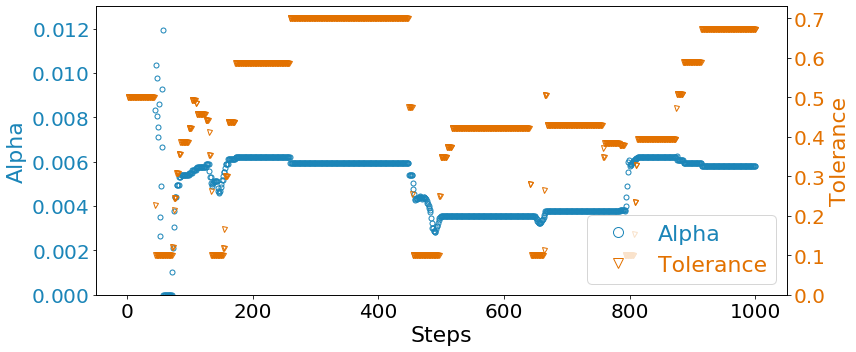

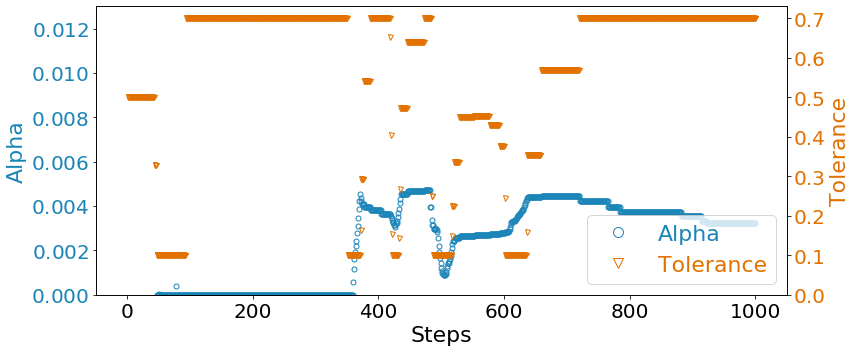

In [70]:
graph_tol_alpha('dynamic', results_d, 500)
graph_tol_alpha('dynamic', results_d, 800) ## results, temperature

## Static Alpha --  Alpha and Tolerance

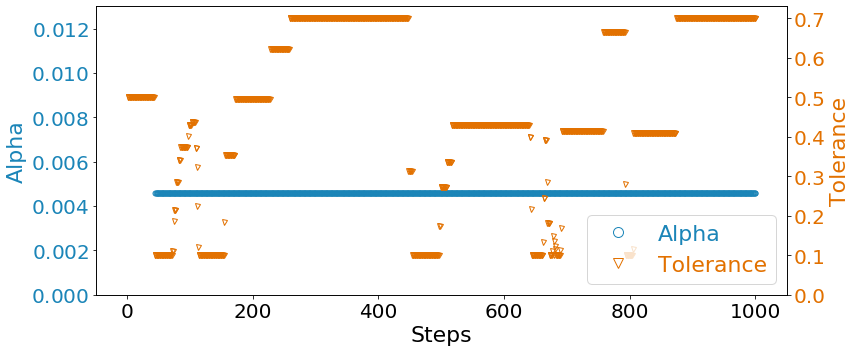

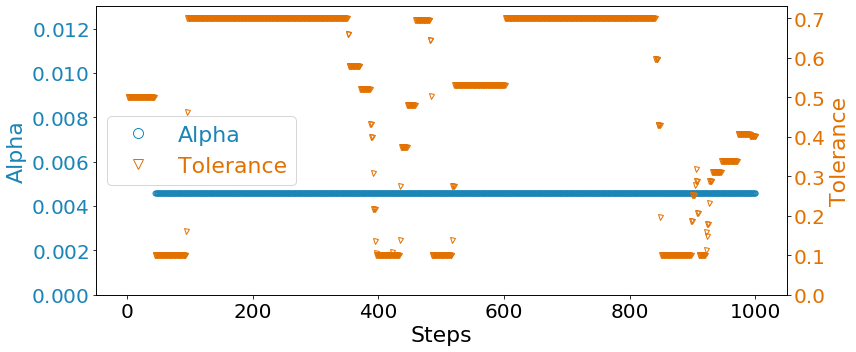

In [71]:
graph_tol_alpha('static', results_s, 500)
graph_tol_alpha('static', results_s, 800)

## Energy VS True Energy

In [41]:
def get_true_run(true_energy, surrogate_energy_true, surrogate_energy_values):
    e_true = np.array(true_energy[0:])
    e_used = np.array(true_energy[0:])
    for s, e in zip(surrogate_energy_true['step'], surrogate_energy_values):
        e_used[s-1] = e

    return e_used

def energy_vs_graph(kind):
    offset = -1081.0115
    if kind=='simple':
        app = "08Oct20-205633_p_0.003_uq_0.2_T_500_I_300_M_1" ## Can find single results in data directory
        results = pd.read_csv(root_path + "/SS_RI300/"+ app + "/tests_run_data.csv")
        label = 'Simple'
        color = colors[1]
        marker= 'o'
    else:
        app = "14Oct20-151642_p_0.003_uq_0.5_T_500_I_1_M_1" ## Can find single results in data directory
        results = pd.read_csv(root_path + "/NORT-Proxima_dynamicalpha/"+ app + "/tests_run_data.csv")
        label = 'Other'
        color = colors[0]
        marker= 'v'

    fig, ax = plt.subplots(figsize=(FIGWIDTH,7))
    
    surrogate_energy_true = results[results['surrogate'] == True]
    surrogate_energy_values = surrogate_energy_true['surrogate_energy']
    new_energy = results[results['surrogate']== False]
    new_energy_val = new_energy['new_energy']
    true_energy = results['true_new_energy']
    #import pdb; pdb.set_trace()
    e_used = get_true_run(true_energy, surrogate_energy_true, surrogate_energy_values)
    plt.plot(true_energy[0:]-offset, e_used-offset, marker, fillstyle='none', markersize=5, label=label, color=color)
    ax.ticklabel_format(axis='x', style='scientific', scilimits=(0,0), useMathText=True) # useOffset=False)
    ax.ticklabel_format(axis='y', style='scientific', scilimits=(0,0), useMathText=True) # useOffset=False)
    #ax.ticklabel_format(axis='y',style='scientific',scilimits=(-3,3))
    plt.xticks(fontsize=MEDIUM)
    plt.yticks(fontsize=MEDIUM)
    plt.ylim((-0.02,0.03))
    plt.xlim((-0.017,0.016))
    ax.yaxis.get_offset_text().set_fontsize(MEDIUM)
    ax.xaxis.get_offset_text().set_fontsize(MEDIUM)
    ax.plot([-0.025, 0.02], [-0.025, 0.02], color='black', lw=1, label='Linear')

    plt.ylabel('Predicted energy', fontsize=BIG)
    plt.xlabel('True energy', fontsize=BIG)
    plt.legend(fontsize=BIG, markerscale=2)
    plt.tight_layout()
    
    if kind=='simple':
        plt.savefig('Figures/EnergyVS_SS.pdf')
    else:
        plt.savefig('Figures/EnergyVS_ProxD.pdf')
        
def plot_one(results, label, marker, color, alpha):
    offset = -1081.0115
    surrogate_energy_true = results[results['surrogate'] == True]
    surrogate_energy_values = surrogate_energy_true['surrogate_energy']
    new_energy = results[results['surrogate']== False]
    new_energy_val = new_energy['new_energy']
    true_energy = results['true_new_energy']
    e_used = get_true_run(true_energy, surrogate_energy_true, surrogate_energy_values)
    plt.plot(true_energy[0:]-offset, e_used-offset, marker, fillstyle='none', color=color, markersize=5, label=label, alpha=alpha)
        
def energy_vs_graph_both():
    app_simple = "08Oct20-205633_p_0.003_uq_0.2_T_500_I_300_M_1" ## Can find single results in data directory
    results_simple = pd.read_csv(root_path + "/SS_RI300/"+ app_simple + "/tests_run_data.csv")
    app_other = "14Oct20-151642_p_0.003_uq_0.5_T_500_I_1_M_1" ## Can find single results in data directory
    results_other = pd.read_csv(root_path + "/NORT-Proxima_dynamicalpha/"+ app_other + "/tests_run_data.csv")

    fig, ax = plt.subplots(figsize=(FIGWIDTH,7))
    
    plot_one(results_simple, 'Simple', 'o', colors[1], 1)
    plot_one(results_other,  'Other',  'v', colors[0], 0.5)
    ax.plot([-0.025, 0.02], [-0.025, 0.02], color='black', lw=1, label='Linear')

    ax.ticklabel_format(axis='x', style='scientific', scilimits=(0,0), useMathText=True) # useOffset=False)
    ax.ticklabel_format(axis='y', style='scientific', scilimits=(0,0), useMathText=True) # useOffset=False)
    #ax.ticklabel_format(axis='y',style='scientific',scilimits=(-3,3))
    plt.xticks(fontsize=MEDIUM)
    plt.yticks(fontsize=MEDIUM)
    plt.ylim((-0.02,0.03))
    plt.xlim((-0.017,0.016))
    ax.yaxis.get_offset_text().set_fontsize(MEDIUM)
    ax.xaxis.get_offset_text().set_fontsize(MEDIUM)
    #ax.axline(, color='r', linewidth=1)


    plt.ylabel('Predicted energy', fontsize=BIG)
    plt.xlabel('True energy', fontsize=BIG)
    plt.legend(loc='upper left', fontsize=BIG, markerscale=2)
    plt.tight_layout()
    
    plt.savefig('Figures/EnergyVS_SS_ProxD.pdf')

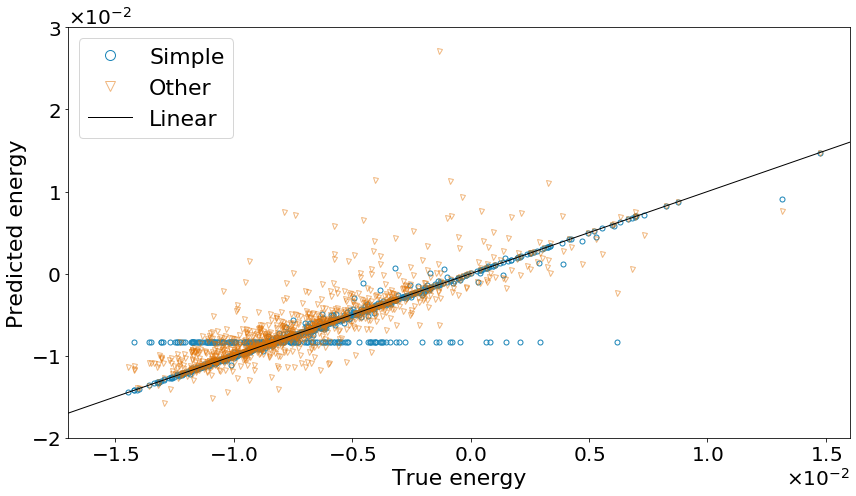

In [42]:
energy_vs_graph_both()

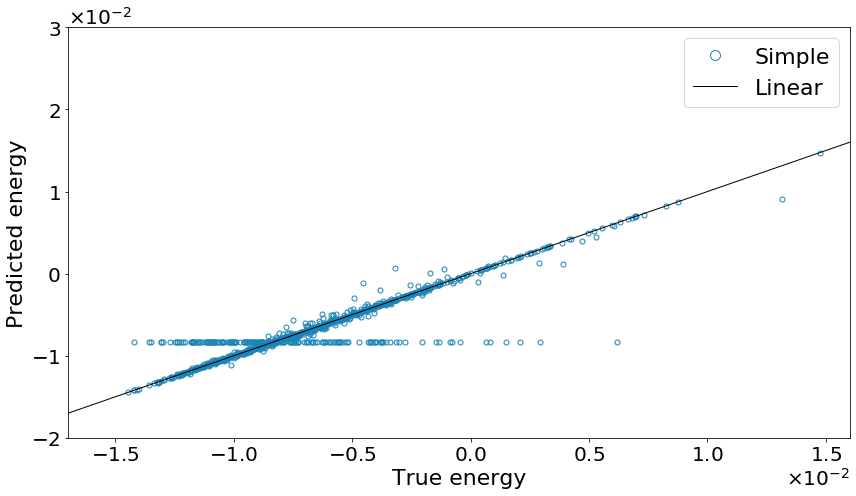

In [43]:
energy_vs_graph('simple')

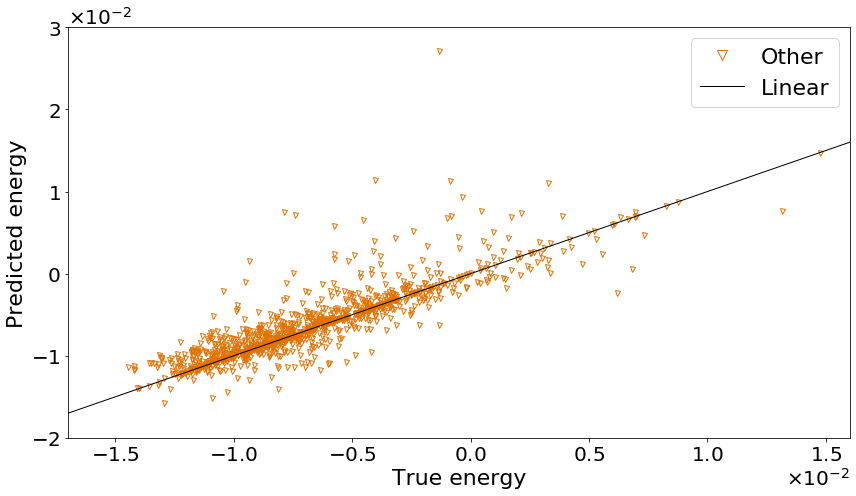

In [44]:
energy_vs_graph('other')

# 3) MAE Speedup Bar Charts

In [45]:
def graph_values(name):
    _t_sa = results[name]['time']
    _speedup_sa = results[name]['speed_up']
    _temp_sa = results[name]['temperature']
    _mae_sa = results[name]['mae']
   
    _temp_sa, _t_sa, _mae_sa = zip(*sorted(zip(_temp_sa, _t_sa,_mae_sa)))
    hm_mae_sa = stat.harmonic_mean(_mae_sa)
    hm_t_sa = stat.harmonic_mean(_t_sa)
    _mae_sa = _mae_sa + (hm_mae_sa,)
    _t_sa = _t_sa + (hm_t_sa,)
    _temp_sa = _temp_sa + ('HM',)
    return _mae_sa,_t_sa, _temp_sa
    
_mae_sa,_t_sa,_temp_sa = graph_values("NORT-Proxima_static-alpha")
_mae_da,_t_da,_temp_da = graph_values("NORT-Proxima_dynamicalpha")
_mae_ssnort,_t_ssnort, _temp_ssnort = graph_values("SS-UQ02-NORT_staticalpha")
_mae_ss,_t_ss,_temp_ss = graph_values("SS-UQ02_I50")
_mae_ss300,_t_ss300,_temp_ss300 = graph_values("SS_RI300")
_mae_nostreak, _t_nostreak, _temp_nostreak = graph_values("dyn_nostreak")

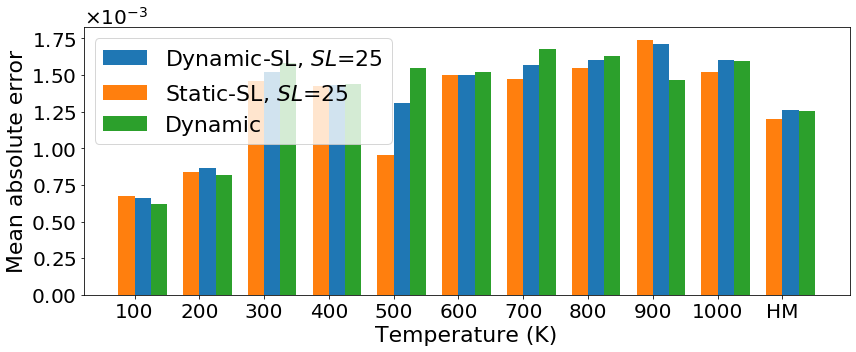

In [46]:
RI= True #set true or false depending on retrain interval usage
SS = False #Comparing with simple surrogate
labels = list(_temp_ssnort)

x = np.arange(len(labels))  # the label locations
fig, ax = plt.subplots(figsize=(FIGWIDTH,5))

rects1 = ax.bar(x + WIDTH/2, list(_mae_da), WIDTH, label=r'Dynamic-SL, $SL$=25')
rects2 = ax.bar(x - WIDTH/2, list(_mae_sa), WIDTH, label='Static-SL, $SL$=25')
rects4 = ax.bar(x + (WIDTH/2)+WIDTH, list(_mae_nostreak), WIDTH, label='Dynamic')
if SS:
    if RI:
        rects3 = ax.bar(x + (WIDTH/2)+WIDTH*2, list(_mae_ss300), WIDTH, label=r'Fixed, $T$=0.2, $RI$=300')
    else:
        rects3 = ax.bar(x + (WIDTH/2)+WIDTH*2, list(_mae_ssnort), WIDTH, label=r'Fixed, $T$=0.2, $RI$=lazy')


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Mean absolute error', fontsize=BIG)
ax.set_xlabel("Temperature (K)", fontsize=BIG)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.yaxis.get_offset_text().set_fontsize(MEDIUM)
ax.ticklabel_format(axis='y', style='scientific', scilimits=(0,0), useMathText=True)
plt.xticks(fontsize=MEDIUM)
plt.yticks(fontsize=MEDIUM)
ax.legend(fontsize=BIG)
plt.tight_layout()
plt.savefig('Figures/3prox_MAEbar.pdf')

# 4) Speedup Bar Chart

In [47]:
def graph_values_speedup(name):
    _t_sa = results[name]['time']
    _speedup_sa = results[name]['speed_up']
    _temp_sa = results[name]['temperature']
   
    _temp_sa, _t_sa, _speedup_sa = zip(*sorted(zip(_temp_sa, _t_sa,_speedup_sa)))
    hm_sp_sa = stat.harmonic_mean(_speedup_sa)
    hm_t_sa = stat.harmonic_mean(_t_sa)
    _speedup_sa = _speedup_sa + (hm_sp_sa,)
    _t_sa = _t_sa + (hm_t_sa,)
    _temp_sa = _temp_sa + ('HM',)
    return _speedup_sa,_t_sa, _temp_sa
    
_speedup_sa,_t_sa,_temp_sa = graph_values_speedup("NORT-Proxima_static-alpha")
_speedup_da,_t_da,_temp_da = graph_values_speedup("NORT-Proxima_dynamicalpha")
_speedup_ssnort,_t_ssnort, _temp_ssnort = graph_values_speedup("SS-UQ02-NORT_staticalpha")
_speedup_ss,_t_ss,_temp_ss = graph_values_speedup("SS-UQ02_I50")
_speedup_ss300,_t_ss300,_temp_ss300 = graph_values_speedup("SS_RI300")
_speedup_nostreak, _t_nostreak, _temp_nostreak = graph_values_speedup("dyn_nostreak")

## Graphing Speed-up Comparison: Dynamic vs Simple Surrogate No Retrain Interval 
Simple surrogate uses UQ: 0.2

In [48]:
def graph_speedup(RI, _speedup_da, _speedup_sa, _speedup_ss300, _speedup_ssnort):
    labels = list(_temp_ssnort)

    x = np.arange(len(labels))  # the label locations
    fig, ax = plt.subplots(figsize=(FIGWIDTH,5))

    rects1 = ax.bar(x - WIDTH/2, list(_speedup_da), WIDTH, label='Dynamic-SL, $SL$=25')
    rects2 = ax.bar(x + WIDTH/2, list(_speedup_sa), WIDTH, label='Static-SL, $SL$=25')
    if RI:
        rects3 = ax.bar(x + (WIDTH/2)+WIDTH, list(_speedup_ss300), WIDTH, label=r'Fixed, $T$=0.2, $RI$=300')
    else:
        rects3 = ax.bar(x + (WIDTH/2)+WIDTH, list(_speedup_ssnort), WIDTH, label=r'Fixed, $T$=0.2, $RI$=lazy')

    ax.set_ylabel('Speedup', fontsize=BIG)
    ax.set_xlabel('Temperature (K)', fontsize=BIG)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    plt.xticks(fontsize=MEDIUM)
    plt.yticks(fontsize=MEDIUM)
    ax.legend(fontsize=BIG)
    plt.tight_layout()

    if RI:
        plt.savefig('Figures/speedup_best.pdf')
    else:
        plt.savefig('Figures/nort_speedup_bar.pdf')

    plt.show()

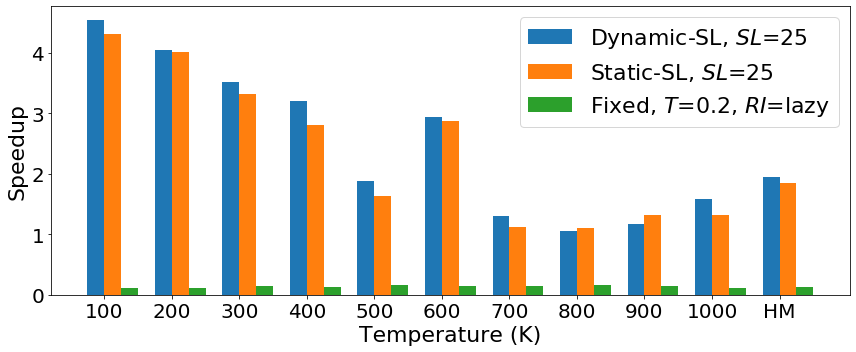

In [49]:
graph_speedup(False, _speedup_da, _speedup_sa, _speedup_ss300, _speedup_ssnort)

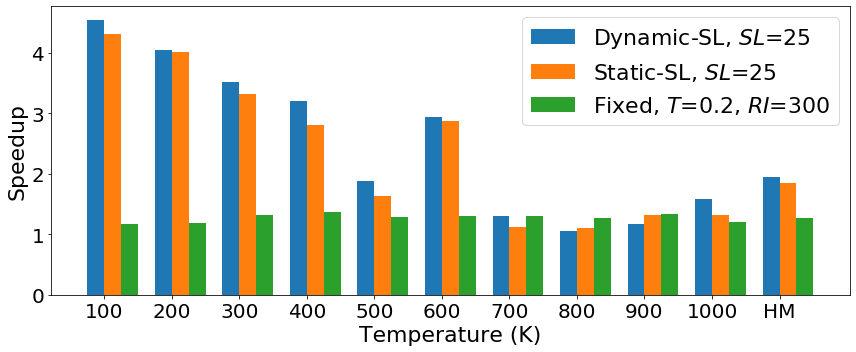

In [50]:
graph_speedup(True, _speedup_da, _speedup_sa, _speedup_ss300, _speedup_ssnort)

## Dynamic, Static, No streak VS SS with RI 300

In [51]:
def graph_more_speedup(RI, SS, _speedup_da, _speedup_sa, _speedup_ss300, _speedup_ssnort):
    labels = list(_temp_ssnort)
    
    if SS:
        width=NARROW
    else:
        width=WIDTH

    x = np.arange(len(labels))  # the label locations
    fig, ax = plt.subplots(figsize=(FIGWIDTH,5))
    
    halfwidth = width/2
    offset1 = -1*halfwidth
    offset2 =  1*halfwidth
    offset3 =  3*halfwidth
    offset4 =  5*halfwidth

    rects1 = ax.bar(x + offset1, list(_speedup_nostreak), width, label='Dynamic')
    rects2 = ax.bar(x + offset2, list(_speedup_da), width, label=r'Dynamic-SL, $SL$=25')
    rects3 = ax.bar(x + offset3, list(_speedup_sa), width, label='Static-SL, $SL$=25')
    if SS:
        if RI:
            rects4 = ax.bar(x + offset4, list(_speedup_ss300), width, label=r'Fixed, $T$=0.2, $RI$=300')
        else:
            rects4 = ax.bar(x + offset4, list(_speedup_ssnort), width, label=r'Fixed, $T$=0.2, $RI$=lazy')

    ax.set_ylabel('Speed-up', fontsize=BIG)
    ax.set_xlabel('Temperature (K)', fontsize=BIG)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    plt.xticks(fontsize=MEDIUM)
    plt.yticks(fontsize=MEDIUM)
    ax.legend(fontsize=BIG)
    plt.tight_layout()
    
    plt.savefig('Figures/3prox_speedupbar.pdf')
    plt.show()

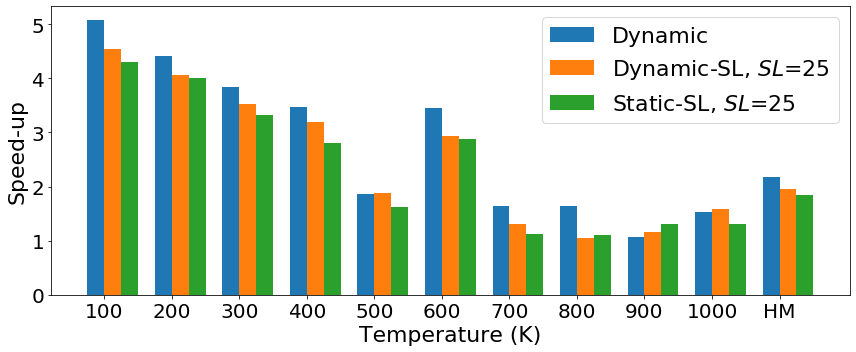

In [52]:
graph_more_speedup(True, False, _speedup_da, _speedup_sa, _speedup_ss300, _speedup_ssnort)

### Graphing Speed-up Comparison: Dynamic, NO surrogate streak vs Simple Surrogate with 300 RI
Simple surrogate uses UQ: 0.2

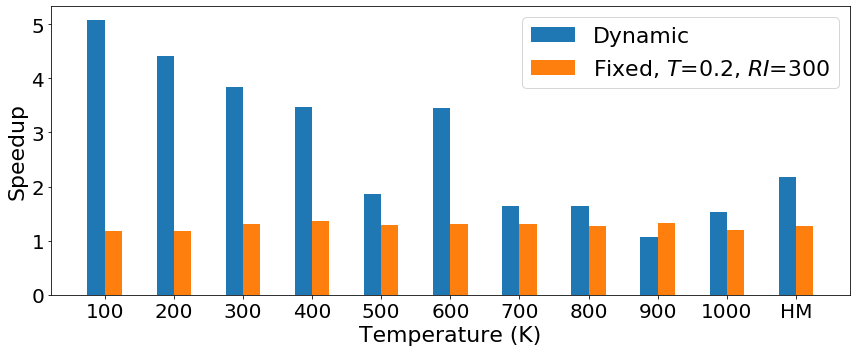

In [53]:
labels = list(_temp_ssnort)

x = np.arange(len(labels))  # the label locations
fig, ax = plt.subplots(figsize=(FIGWIDTH,5))
rects1 = ax.bar(x - WIDTH/2, list(_speedup_nostreak), WIDTH, label=r'Dynamic')
rects2 = ax.bar(x + WIDTH/2, list(_speedup_ss300), WIDTH, label=r'Fixed, $T$=0.2, $RI$=300')

ax.set_ylabel('Speedup', fontsize=BIG)
ax.set_xlabel('Temperature (K)', fontsize=BIG)
ax.set_xticks(x)
ax.set_xticklabels(labels)
plt.xticks(fontsize=MEDIUM)
plt.yticks(fontsize=MEDIUM)
ax.legend(fontsize=BIG)
plt.tight_layout()

plt.savefig('Figures/nostreak_ss_bar.pdf')
plt.show()

## Graphing Speed-up Comparison: Dynamic vs Simple Surrogate with 300 RI
Simple surrogate uses UQ: 0.2

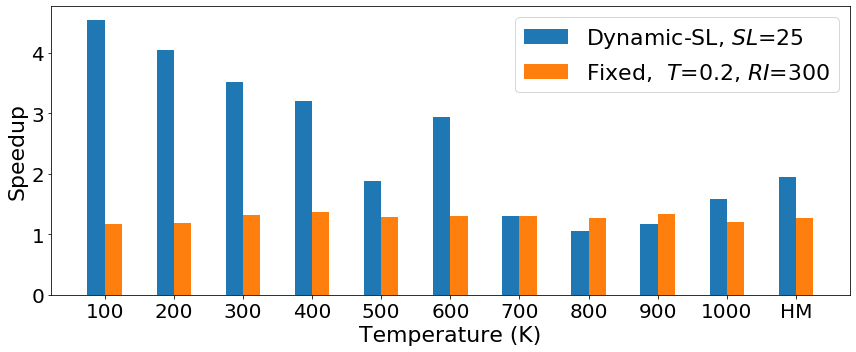

In [54]:
labels = list(_temp_ssnort)

x = np.arange(len(labels))  # the label locations
fig, ax = plt.subplots(figsize=(FIGWIDTH,5))
rects1 = ax.bar(x - WIDTH/2, list(_speedup_da), WIDTH, label=r'Dynamic-SL, $SL$=25')
rects2 = ax.bar(x + WIDTH/2, list(_speedup_ss300), WIDTH, label=r'Fixed,  $T$=0.2, $RI$=300')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Speedup', fontsize=BIG)
ax.set_xticks(x)
ax.set_xlabel('Temperature (K)', fontsize=BIG)
ax.set_xticklabels(labels)
plt.xticks(fontsize=MEDIUM)
plt.yticks(fontsize=MEDIUM)
ax.legend(fontsize=BIG)
plt.tight_layout()

plt.savefig('Figures/speedup_best300.pdf')
plt.show()

## Graphing Time Comparison: Dynamic vs Static Proxima

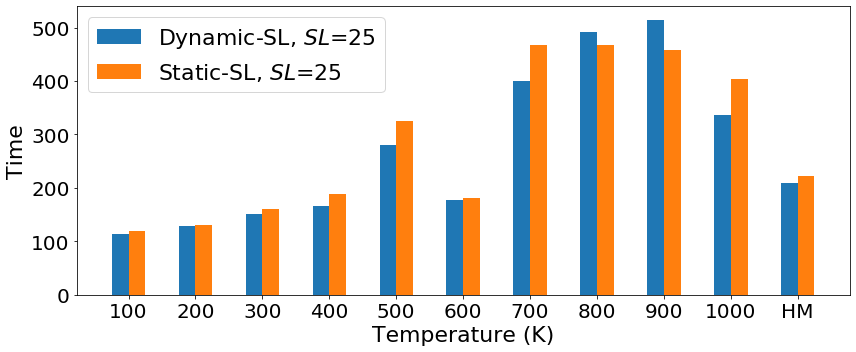

In [55]:
labels = list(_temp_sa)

x = np.arange(len(labels))  # the label locations
fig, ax = plt.subplots(figsize=(FIGWIDTH,5))

rects1 = ax.bar(x - WIDTH/2, list(_t_da), WIDTH, label=r'Dynamic-SL, $SL$=25')
rects2 = ax.bar(x + WIDTH/2, list(_t_sa), WIDTH, label=r'Static-SL, $SL$=25')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Time', fontsize=BIG)
ax.set_xlabel('Temperature (K)', fontsize=BIG)
ax.set_xticks(x)
ax.set_xticklabels(labels)
plt.xticks(fontsize=MEDIUM)
plt.yticks(fontsize=MEDIUM)
ax.legend(fontsize=BIG)
plt.tight_layout()

plt.show()

## Graphing Speed-up: Dynamic vs Static Proxima

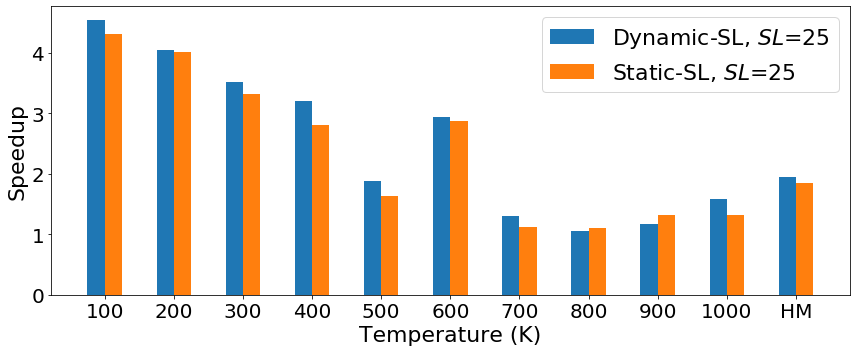

In [56]:
labels = list(_temp_sa)

x = np.arange(len(labels))  # the label locations
fig, ax = plt.subplots(figsize=(FIGWIDTH,5))

rects1 = ax.bar(x - WIDTH/2, list(_speedup_da), WIDTH, label=r'Dynamic-SL, $SL$=25') # r'$\sin (x)$'
rects2 = ax.bar(x + WIDTH/2, list(_speedup_sa), WIDTH, label=r'Static-SL, $SL$=25')

ax.set_ylabel('Speedup', fontsize=BIG)
ax.set_xlabel('Temperature (K)', fontsize=BIG)
ax.set_xticks(x)
ax.set_xticklabels(labels)
plt.xticks(fontsize=MEDIUM)
plt.yticks(fontsize=MEDIUM)
ax.legend(fontsize=BIG)
plt.tight_layout()

plt.show()

## Function to graph cases - only works with two cases

In [57]:
def _plot_cases2(cases):
    fig, ax = plt.subplots(figsize=(FIGWIDTH,5))
    num_case = len(cases)
    total_width = 0.7
    #width total_width / num_case
    for i in range(num_case):
        case = cases[i]
        x_offset = (i - num_case / 2) * WIDTH + WIDTH / 2
        labels = list(case.get('df'))
        x = np.arange(len(labels))  # the label locations
        y = case.get('y')
        label = case.get('label')
        rects1 = ax.bar(x + x_offset, list(y), WIDTH, label=label)

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Time', fontsize=BIG)
    ax.set_xlabel('Temperature (K)', fontsize=BIG)
    ax.set_xticks(x)
    ax.set_xticklabels(labels, fontsize=MEDIUM)
    plt.xticks(fontsize=MEDIUM)
    plt.yticks(fontsize=MEDIUM)
    ax.legend(fontsize=BIG)

In [58]:
cases = (
        {"df": results["NORT-Proxima_dynamicalpha"]['temperature'],'y': results["NORT-Proxima_dynamicalpha"]['time'],"label":r'Dynamic-SL, $SL$=25', "marker":"x"},
        {"df": results["NORT-Proxima_static-alpha"]['temperature'],'y': results["NORT-Proxima_static-alpha"]['time'],"label":r'Static-SL, $SL$=25', "marker":"x"},
        #{"df": results["SS-UQ02-NORT_staticalpha"]['temperature'],'y': results["surrogate_only"]['time'],"label":'Fixed', "marker":"x"},
    )
#_plot_cases(cases)